In [ ]:
from selenium import webdriver
from bs4 import BeautifulSoup
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
driver = webdriver.Firefox(executable_path=r'geckodriver.exe')

In [ ]:
from datetime import date,timedelta
lluvia_diaria = pd.DataFrame(columns=['fecha_registro','probalidad_lluvia','precipitacion','fecha_pronostico'])
fecha = date.today()
for dia in range(1,91):
    driver.get(f"https://www.accuweather.com/es/cl/santiago/60449/daily-weather-forecast/60449?day={dia}")
    content = driver.page_source
    soup = BeautifulSoup(content)
    tabla = soup.find_all('p', {'class': 'panel-item'})
    for i in tabla:
        value = i.get_text(separator=",").split(",")
        if value[0] == "Probabilidad de precipitación":
            probabilidad = float(value[1].replace("%", ""))/100
        if value[0] == "Precipitaciones":
            precipitaciones = float(value[1].replace("mm", ""))
            break
    fecha_pronostico = fecha+timedelta(days=(dia-1))
    lluvia_diaria.loc[len(lluvia_diaria)] = [fecha, probabilidad,precipitaciones, fecha_pronostico]
lluvia_diaria.to_csv(f'data\lluvia_diaria_{fecha}.csv',sep=";",decimal=",",index=False)


In [12]:
lluvia_diaria_23 = pd.read_csv('data/lluvia_diaria_2022-05-23.csv',sep=";",decimal=",")
lluvia_diaria_24 = pd.read_csv('data/lluvia_diaria_2022-05-24.csv',sep=";",decimal=",")


In [13]:
lluvia_esperada_total = pd.concat([lluvia_diaria_23,lluvia_diaria_24])
lluvia_esperada_total.reset_index(drop=True,inplace=True)
lluvia_esperada_total['lluvia_esperada'] = lluvia_esperada_total['probalidad_lluvia']*lluvia_esperada_total['precipitacion']


In [14]:
lluvia_esperada_total.groupby(['fecha_registro'])['lluvia_esperada'].sum()

fecha_registro
2022-05-23    87.342
2022-05-24    79.965
Name: lluvia_esperada, dtype: float64

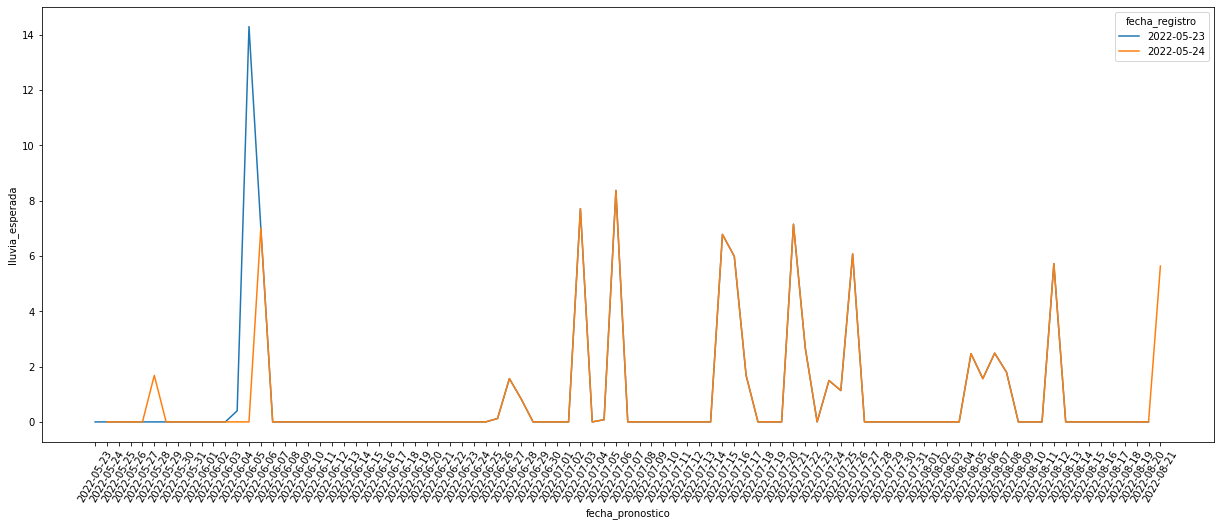

In [15]:
plt.figure(figsize = (21,8))
ax = sns.lineplot(data=lluvia_esperada_total, x='fecha_pronostico',y='lluvia_esperada',hue='fecha_registro')
plt.xticks(rotation=60)
plt.show()